In this notebook, we are trying to 
- answer these questions:
	- Is it 'easier' to get promoted in certain departments?
		- Check promoted people’s training score vs. not promoted
		- Check awards and KPI
		- previous year rating
		- number of trainings 
		- does education matter?
		- does recruitment channel matter?
		- Split up gender for each question
- Create a KNN model that predicts 




In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, f1_score

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project_3/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(drive_dir + 'data/promotion_train_data.csv')

#Cleaning Data

In [ ]:
df.shape

(54808, 14)

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df = df.drop('employee_id',axis = 1)

In [ ]:
for col in df.columns:
  percent = 100 * df[col].isna().sum() / df.shape[0]
  percent = round(percent,2)
  print(f'{col}: {df[col].isna().sum()} ({percent}%) missing values')

department: 0 (0.0%) missing values
region: 0 (0.0%) missing values
education: 2409 (4.4%) missing values
gender: 0 (0.0%) missing values
recruitment_channel: 0 (0.0%) missing values
no_of_trainings: 0 (0.0%) missing values
age: 0 (0.0%) missing values
previous_year_rating: 4124 (7.52%) missing values
length_of_service: 0 (0.0%) missing values
KPIs_met >80%: 0 (0.0%) missing values
awards_won?: 0 (0.0%) missing values
avg_training_score: 0 (0.0%) missing values
is_promoted: 0 (0.0%) missing values


In [ ]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [ ]:
#Replacing NaN instead of dropping b/c I want to keep those rows
df['education'] = df.education.fillna('Unknown')

In [ ]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [ ]:
#Ratings are 1-5, so 0 will mean employee was not here last year
df['previous_year_rating'] = df.previous_year_rating.fillna(0)

In [ ]:
df['starting_age'] = df['age']-df['length_of_service']

In [ ]:
df['total_training_score'] = df['no_of_trainings']*df['avg_training_score']

In [ ]:
df = df.rename(columns={'KPIs_met >80%': 'KPIs_met>80%'})

In [ ]:
c

In [ ]:
#based off of percentages of promotion. Lowered older than 40 with 0 rating bc only 11 people
def age_rating(row):
  if row['age'] <= 40 and row['previous_year_rating'] == 0:
    return 10
  elif row['age'] <= 40 and row['previous_year_rating'] == 1:
    return 2
  elif row['age'] <= 40 and row['previous_year_rating'] == 2:
    return 4
  elif row['age'] <= 40 and row['previous_year_rating'] == 3:
    return 7
  elif row['age'] <= 40 and row['previous_year_rating'] == 4:
    return 9
  elif row['age'] <= 40 and row['previous_year_rating'] == 5:
    return 12
  elif row['age'] > 40 and row['previous_year_rating'] == 0:
    return 6
  elif row['age'] > 40 and row['previous_year_rating'] == 1:
    return 1
  elif row['age'] > 40 and row['previous_year_rating'] == 2:
    return 3
  elif row['age'] > 40 and row['previous_year_rating'] == 3:
    return 5
  elif row['age'] > 40 and row['previous_year_rating'] == 4:
    return 8
  else:
    return 11


In [ ]:
def age_KPI(row):
  if row['age'] <= 45 and row['KPIs_met>80%'] == 0:
    return 2
  elif row['age'] <= 45 and row['KPIs_met>80%'] == 1:
    return 4
  elif row['age'] > 45 and row['KPIs_met>80%'] == 0:
    return 3
  else:
    return 1

In [ ]:
df['age_rating'] = df.apply(age_rating, axis=1)

In [ ]:
df['age_KPI'] = df.apply(age_KPI, axis=1)

In [ ]:
df.dtypes

department                  object
region                      object
education                   object
gender                      object
recruitment_channel         object
no_of_trainings              int64
age                          int64
previous_year_rating       float64
length_of_service            int64
KPIs_met>80%                 int64
awards_won?                  int64
avg_training_score           int64
is_promoted                  int64
starting_age                 int64
total_training_score         int64
department_num               int64
region_num                   int64
education_num                int64
recruitment_channel_num      int64
age_rating                   int64
age_KPI                      int64
dtype: object

In [ ]:
df.isna().sum()

department                 0
region                     0
education                  0
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPIs_met>80%               0
awards_won?                0
avg_training_score         0
is_promoted                0
starting_age               0
total_training_score       0
department_num             0
region_num                 0
education_num              0
recruitment_channel_num    0
age_rating                 0
age_KPI                    0
dtype: int64

In [ ]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,department_num,region_num,education_num,recruitment_channel_num,age_rating,age_KPI
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,7,31,2,2,12,4
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,4,14,0,0,12,2
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,7,10,0,2,7,2
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,7,15,0,0,2,2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,8,18,0,0,5,2


In [ ]:
male_df = df[df['gender'] == 'm']
female_df = df[df['gender'] == 'f']

In [ ]:
met_KPI_male_df = male_df[male_df['KPIs_met>80%'] == 1]
no_met_KPI_male_df = male_df[male_df['KPIs_met>80%'] != 1]
met_KPI_female_df = female_df[female_df['KPIs_met>80%'] == 1]
no_met_KPI_female_df = female_df[female_df['KPIs_met>80%'] != 1]

#Looking for general facts

In [ ]:
#Rating 0 means they were not there last year
#What do these 8% of people do to get promoted?
for i in df['previous_year_rating'].unique():
  rating_df = df[df['previous_year_rating'] == i]
  total = rating_df.shape[0]
  promoted = rating_df[rating_df['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employee's with previous year rating {i} were promoted {percent: .2f}% of the time. ({promoted} out of {total})")

Employee's with previous year rating 5.0 were promoted  16.36% of the time. (1921 out of 11741)
Employee's with previous year rating 3.0 were promoted  7.28% of the time. (1355 out of 18618)
Employee's with previous year rating 1.0 were promoted  1.41% of the time. (88 out of 6223)
Employee's with previous year rating 4.0 were promoted  7.94% of the time. (784 out of 9877)
Employee's with previous year rating 0.0 were promoted  8.22% of the time. (339 out of 4124)
Employee's with previous year rating 2.0 were promoted  4.28% of the time. (181 out of 4225)


In [ ]:
zero_df = df[df['previous_year_rating'] == 0]

In [ ]:
#Looks like average training score is an important factor for promotions
#0 is not promoted
#1 is promoted
for i, group in zero_df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for {i} with a 0 previous year rating was {training_score_mean}")

for i, group in df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for all people for {i} rating was {training_score_mean}")


The average training score for 0 with a 0 previous year rating was 62.589696169088505
The average training score for 1 with a 0 previous year rating was 71.929203539823
The average training score for all people for 0 rating was 62.64768647786199
The average training score for all people for 1 rating was 71.32519280205655


#Here we are looking to answer:
- Is it 'easier' to get promoted in certain departments?

In [ ]:
#Percent of people to get promoted in each category
def promo_by_group(col):
  for i,group in df.groupby(col):
    total = group.shape[0]
    promoted = group[group['is_promoted'] == 1].shape[0]
    percent = 100*promoted/total
    print(f"{i}: promoted {percent:.2f}% of the time. ({promoted} out of {total})")

In [ ]:
#Percent of people to get promoted in each category by gender
def promo_by_group_gender(col):
  for i,group in df.groupby(col):
    male_df = group[group['gender'] == 'm']
    female_df = group[group['gender'] == 'f']
    total_male = male_df.shape[0]
    total_female = female_df.shape[0]
    promoted_male = male_df[male_df['is_promoted'] == 1].shape[0]
    promoted_female = female_df[female_df['is_promoted'] == 1].shape[0]
    if total_male == 0:
      print('There are no males in this category')
      return None
    if total_female == 0:
      print('There are no females in this category')
      return None
    percent_male = 100*promoted_male/total_male
    percent_female = 100*promoted_female/total_female
    print(f"{i} Males:  were promoted {percent_male:.2f}% of the time. ({promoted_male} out of {total_male})")
    print(f"{i} Females: department were promoted {percent_female:.2f}% of the time. ({promoted_female} out of {total_female})")
    print('='*100)

In [ ]:
category = ['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings','age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?']

for col in category:
  print(col.upper(), ':')
  print(promo_by_group(col))
  print("="*100)

DEPARTMENT :
Analytics: promoted 9.57% of the time. (512 out of 5352)
Finance: promoted 8.12% of the time. (206 out of 2536)
HR: promoted 5.62% of the time. (136 out of 2418)
Legal: promoted 5.10% of the time. (53 out of 1039)
Operations: promoted 9.01% of the time. (1023 out of 11348)
Procurement: promoted 9.64% of the time. (688 out of 7138)
R&D: promoted 6.91% of the time. (69 out of 999)
Sales & Marketing: promoted 7.20% of the time. (1213 out of 16840)
Technology: promoted 10.76% of the time. (768 out of 7138)
None
REGION :
region_1: promoted 9.51% of the time. (58 out of 610)
region_10: promoted 7.87% of the time. (51 out of 648)
region_11: promoted 5.63% of the time. (74 out of 1315)
region_12: promoted 6.60% of the time. (33 out of 500)
region_13: promoted 8.69% of the time. (230 out of 2648)
region_14: promoted 7.50% of the time. (62 out of 827)
region_15: promoted 7.91% of the time. (222 out of 2808)
region_16: promoted 6.96% of the time. (102 out of 1465)
region_17: promoted

In [ ]:
category_no_gender = ['department', 'region', 'education', 'recruitment_channel',
       'no_of_trainings','age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?']

for col in category_no_gender:
  print(col.upper(),":")
  print(promo_by_group_gender(col))
  print("-"*150)

DEPARTMENT :
Analytics Males:  were promoted 9.30% of the time. (450 out of 4839)
Analytics Females: department were promoted 12.09% of the time. (62 out of 513)
Finance Males:  were promoted 8.14% of the time. (151 out of 1855)
Finance Females: department were promoted 8.08% of the time. (55 out of 681)
HR Males:  were promoted 5.52% of the time. (78 out of 1412)
HR Females: department were promoted 5.77% of the time. (58 out of 1006)
Legal Males:  were promoted 5.28% of the time. (47 out of 890)
Legal Females: department were promoted 4.03% of the time. (6 out of 149)
Operations Males:  were promoted 8.71% of the time. (581 out of 6671)
Operations Females: department were promoted 9.45% of the time. (442 out of 4677)
Procurement Males:  were promoted 7.87% of the time. (303 out of 3851)
Procurement Females: department were promoted 11.71% of the time. (385 out of 3287)
R&D Males:  were promoted 6.69% of the time. (63 out of 942)
R&D Females: department were promoted 10.53% of the tim

In [ ]:
#Finding average training score for those who were promoted and not promoted
for department,group in df.groupby('department'):
  promoted_df = group[group['is_promoted'] == 1]
  not_promoted_df = group[group['is_promoted'] == 0]
  training_score_promo = promoted_df['avg_training_score'].mean()
  training_score_not_promo = not_promoted_df['avg_training_score'].mean()
  print(f"Employees in the {department} department who were promoted had an average training score of {training_score_promo}")
  print(f"Employees in the {department} department who were NOT promoted had an average training score of {training_score_not_promo}")
  print('='*125)

Employees in the Analytics department who were promoted had an average training score of 85.833984375
Employees in the Analytics department who were NOT promoted had an average training score of 84.47272727272727
Employees in the Finance department who were promoted had an average training score of 68.63106796116504
Employees in the Finance department who were NOT promoted had an average training score of 59.47854077253219
Employees in the HR department who were promoted had an average training score of 57.89705882352941
Employees in the HR department who were NOT promoted had an average training score of 49.54864154250657
Employees in the Legal department who were promoted had an average training score of 66.41509433962264
Employees in the Legal department who were NOT promoted had an average training score of 59.51622718052738
Employees in the Operations department who were promoted had an average training score of 67.2218963831867
Employees in the Operations department who were NOT 

#Looking for possible columns to add

In [ ]:
def split_age(df, col, age):

  for att, group in df.groupby(col):

    older_df = group[group['age'] > age]
    older_total = older_df.shape[0]
    older_promote = older_df[older_df['is_promoted'] == 1].shape[0]
    older_pct = 100*older_promote/older_total

    younger_df = group[group['age'] <= age]
    younger_total = younger_df.shape[0]
    younger_promote = younger_df[younger_df['is_promoted'] == 1].shape[0]
    younger_pct = 100*younger_promote/younger_total

    print(f'People younger than {age+1} with {col} {att} are promoted {younger_pct: .2f}% of the time. ({younger_promote} out of {younger_total})')
    print(f'People older than {age} with {col} {att} are promoted {older_pct: .2f}% of the time. ({older_promote} out of {older_total})')
    #print('-'*150)

In [ ]:
#Doesn't seem to be a huge difference
for age in np.linspace(25,55,5):
  split_age(female_df, 'awards_won?', age)
  print('='*125)

People younger than 26.0 with awards_won? 0 are promoted  5.16% of the time. (41 out of 794)
People older than 25.0 with awards_won? 0 are promoted  8.34% of the time. (1263 out of 15149)
People younger than 26.0 with awards_won? 1 are promoted  27.78% of the time. (5 out of 18)
People older than 25.0 with awards_won? 1 are promoted  45.01% of the time. (158 out of 351)
People younger than 33.5 with awards_won? 0 are promoted  7.80% of the time. (565 out of 7239)
People older than 32.5 with awards_won? 0 are promoted  8.49% of the time. (739 out of 8704)
People younger than 33.5 with awards_won? 1 are promoted  40.91% of the time. (72 out of 176)
People older than 32.5 with awards_won? 1 are promoted  47.15% of the time. (91 out of 193)
People younger than 41.0 with awards_won? 0 are promoted  8.58% of the time. (1103 out of 12851)
People older than 40.0 with awards_won? 0 are promoted  6.50% of the time. (201 out of 3092)
People younger than 41.0 with awards_won? 1 are promoted  44.48

In [ ]:
#only big difference is older than 55, but not many people there
for age in np.linspace(25,55,5):
  split_age(male_df, 'awards_won?', age)
  print('='*125)

People younger than 26.0 with awards_won? 0 are promoted  6.31% of the time. (136 out of 2157)
People older than 25.0 with awards_won? 0 are promoted  7.53% of the time. (2669 out of 35438)
People younger than 26.0 with awards_won? 1 are promoted  40.00% of the time. (18 out of 45)
People older than 25.0 with awards_won? 1 are promoted  44.16% of the time. (378 out of 856)
People younger than 33.5 with awards_won? 0 are promoted  7.71% of the time. (1337 out of 17343)
People older than 32.5 with awards_won? 0 are promoted  7.25% of the time. (1468 out of 20252)
People younger than 33.5 with awards_won? 1 are promoted  42.76% of the time. (183 out of 428)
People older than 32.5 with awards_won? 1 are promoted  45.03% of the time. (213 out of 473)
People younger than 41.0 with awards_won? 0 are promoted  7.73% of the time. (2338 out of 30241)
People older than 40.0 with awards_won? 0 are promoted  6.35% of the time. (467 out of 7354)
People younger than 41.0 with awards_won? 1 are promot

In [ ]:
#Reasonable differenec in terms of percentage at age 45, may be worth adding a column
for age in np.linspace(25,55,4):
  split_age(female_df, 'KPIs_met>80%', age)
  print('='*125)


People younger than 26.0 with KPIs_met>80% 0 are promoted  2.71% of the time. (15 out of 553)
People older than 25.0 with KPIs_met>80% 0 are promoted  4.35% of the time. (416 out of 9570)
People younger than 26.0 with KPIs_met>80% 1 are promoted  11.97% of the time. (31 out of 259)
People older than 25.0 with KPIs_met>80% 1 are promoted  16.95% of the time. (1005 out of 5930)
People younger than 36.0 with KPIs_met>80% 0 are promoted  4.45% of the time. (282 out of 6334)
People older than 35.0 with KPIs_met>80% 0 are promoted  3.93% of the time. (149 out of 3789)
People younger than 36.0 with KPIs_met>80% 1 are promoted  17.37% of the time. (674 out of 3881)
People older than 35.0 with KPIs_met>80% 1 are promoted  15.68% of the time. (362 out of 2308)
People younger than 46.0 with KPIs_met>80% 0 are promoted  4.36% of the time. (391 out of 8962)
People older than 45.0 with KPIs_met>80% 0 are promoted  3.45% of the time. (40 out of 1161)
People younger than 46.0 with KPIs_met>80% 1 are p

In [ ]:
for age in np.linspace(25,55,4):
  split_age(male_df, 'KPIs_met>80%', age)
  print('='*125)

People younger than 26.0 with KPIs_met>80% 0 are promoted  3.29% of the time. (50 out of 1521)
People older than 25.0 with KPIs_met>80% 0 are promoted  3.87% of the time. (925 out of 23873)
People younger than 26.0 with KPIs_met>80% 1 are promoted  15.27% of the time. (104 out of 681)
People older than 25.0 with KPIs_met>80% 1 are promoted  17.08% of the time. (2122 out of 12421)
People younger than 36.0 with KPIs_met>80% 0 are promoted  4.06% of the time. (632 out of 15583)
People older than 35.0 with KPIs_met>80% 0 are promoted  3.50% of the time. (343 out of 9811)
People younger than 36.0 with KPIs_met>80% 1 are promoted  17.38% of the time. (1457 out of 8385)
People older than 35.0 with KPIs_met>80% 1 are promoted  16.30% of the time. (769 out of 4717)
People younger than 46.0 with KPIs_met>80% 0 are promoted  3.95% of the time. (895 out of 22639)
People older than 45.0 with KPIs_met>80% 0 are promoted  2.90% of the time. (80 out of 2755)
People younger than 46.0 with KPIs_met>80% 

#Model Building Preperation

In [ ]:
male_X_train_saved = pd.read_csv(drive_dir + 'data/male_X_train.csv')
female_X_train_saved = pd.read_csv(drive_dir + 'data/female_X_train.csv')

male_y_train_saved = pd.read_csv(drive_dir + 'data/male_y_train.csv')
female_y_train_saved = pd.read_csv(drive_dir + 'data/female_y_train.csv')

male_X_test_saved = pd.read_csv(drive_dir + 'data/male_X_test.csv')
female_X_test_saved = pd.read_csv(drive_dir + 'data/female_X_test.csv')

male_y_test_saved = pd.read_csv(drive_dir + 'data/male_y_test.csv')
female_y_test_saved = pd.read_csv(drive_dir + 'data/female_y_test.csv')

In [ ]:
female_feat_cols = ['department', 'KPIs_met>80%', 'avg_training_score']
male_feat_cols = ['department', 'awards_won?', 'avg_training_score']
target_col = 'is_promoted'

female_X_train = female_X_train_saved[female_feat_cols]
female_y_train = female_y_train_saved[target_col]

male_X_train = male_X_train_saved[male_feat_cols]
male_y_train = male_y_train_saved[target_col]

female_X_test = female_X_test_saved[female_feat_cols]
female_y_test = female_y_test_saved[target_col]

male_X_test = male_X_test_saved[male_feat_cols]
male_y_test = male_y_test_saved[target_col]

#Label Encoded columns based off of pct promoted

In [ ]:
train_male_saved_df = male_X_train_saved.copy()
train_male_saved_df['is_promoted'] = male_y_train_saved['is_promoted']

train_female_saved_df = female_X_train_saved.copy()
train_female_saved_df['is_promoted'] = female_y_train_saved['is_promoted']

test_male_saved_df = male_X_test_saved.copy()
test_male_saved_df['is_promoted'] = male_y_test_saved['is_promoted']

test_female_saved_df = female_X_test_saved.copy()
test_female_saved_df['is_promoted'] = female_y_test_saved['is_promoted']

In [ ]:
#creates dictionary with key as the unique values in a column and values as the percent that unique value was promoted
def dict_pct_promoted(col,train_df):
  new_dict = {}
  for value in train_df[col].unique():
    value_df = train_df[train_df[col] == value]
    pct_promoted = 100*value_df[value_df['is_promoted'] == 1].shape[0] / value_df.shape[0]
    new_dict[value] = pct_promoted
  
  return new_dict

In [ ]:
le_col = ['department', 'region', 'education',
       'recruitment_channel', 'no_of_trainings', 'previous_year_rating',
       'length_of_service', 'KPIs_met>80%', 'awards_won?']
def le_pct_promoted_df(df):
  le_df = df.copy()
  for col in le_col:
    col_dict = dict_pct_promoted(col,df)
    le_df[col] = le_df[col].map(col_dict)
  return le_df

In [ ]:
le_train_male_df = le_pct_promoted_df(train_male_saved_df)

In [ ]:
le_train_female_df = le_pct_promoted_df(train_female_saved_df)

In [ ]:
le_test_male_df = le_pct_promoted_df(test_male_saved_df)

In [ ]:
le_test_female_df = le_pct_promoted_df(test_female_saved_df)

In [ ]:
le_col = ['department', 'region', 'education',
       'recruitment_channel', 'no_of_trainings', 'previous_year_rating',
       'length_of_service', 'KPIs_met>80%', 'awards_won?']
le_train_male_df = train_male_saved_df.copy()
for col in le_col:
  col_dict = dict_pct_promoted(col,train_male_saved_df)
  le_train_male_df[col] = le_train_male_df[col].map(col_dict)

In [ ]:
le_train_female_df = train_female_saved_df.copy()
for col in le_col:
  col_dict = dict_pct_promoted(col,train_female_saved_df)
  le_train_female_df[col] = le_train_female_df[col].map(col_dict)

In [ ]:
le_train_male_df = le_train_male_df.drop('Unnamed: 0', axis = 1)

In [ ]:
le_train_female_df = le_train_female_df.drop('Unnamed: 0', axis = 1)

In [ ]:
le_test_male_df = le_test_male_df.drop('Unnamed: 0', axis = 1)

In [ ]:
le_test_female_df = le_test_female_df.drop('Unnamed: 0', axis = 1)

In [ ]:
le_train_female_df.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating',
       'age_KPI', 'is_promoted'],
      dtype='object')

In [ ]:
le_female_feat_cols = ['department','region','recruitment_channel','no_of_trainings','previous_year_rating','KPIs_met>80%','avg_training_score']
le_male_feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating',
       'age_KPI']

le_female_X_train = le_train_female_df[le_female_feat_cols]
le_female_y_train = le_train_female_df[target_col]

le_male_X_train = le_train_male_df[le_male_feat_cols]
le_male_y_train = le_train_male_df[target_col]

le_female_X_test = le_test_female_df[le_female_feat_cols]
le_female_y_test = le_test_female_df[target_col]

le_male_X_test = le_test_male_df[le_male_feat_cols]
le_male_y_test = le_test_male_df[target_col]

In [ ]:
le_female_X_test.to_csv(drive_dir + 'data/le_female_X_test.csv')

In [ ]:
le_female_y_test.to_csv(drive_dir + 'data/le_female_y_test.csv')

##Separating people in KPIs_met>80%: 1 and 0

In [ ]:
met_KPI_female_train_df, met_KPI_female_test_df = train_test_split(met_KPI_female_df, test_size=0.3, random_state=0)
met_KPI_male_train_df, met_KPI_male_test_df = train_test_split(met_KPI_male_df, test_size=0.3, random_state=0)

no_met_KPI_female_train_df, no_met_KPI_female_test_df = train_test_split(no_met_KPI_female_df, test_size=0.3, random_state=0)
no_met_KPI_male_train_df, no_met_KPI_male_test_df = train_test_split(no_met_KPI_male_df, test_size=0.3, random_state=0)

In [ ]:
no_met_KPI_female_feat_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 'is_promoted',
       'starting_age', 'total_training_score', 'department_num', 'region_num',
       'education_num', 'recruitment_channel_num', 'age_rating', 'age_KPI']
no_met_KPI_male_feat_cols = ['department_num', 'avg_training_score']

met_KPI_female_feat_cols = ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 'is_promoted',
       'starting_age', 'total_training_score', 'department_num', 'region_num',
       'education_num', 'recruitment_channel_num', 'age_rating', 'age_KPI']
met_KPI_male_feat_cols = ['department_num', 'no_of_trainings', 'awards_won?', 'avg_training_score']

In [ ]:
no_met_KPI_female_X_train = no_met_KPI_female_train_df[no_met_KPI_female_feat_cols]
no_met_KPI_female_y_train = no_met_KPI_female_train_df[target_col]

no_met_KPI_male_X_train = no_met_KPI_male_train_df[no_met_KPI_male_feat_cols]
no_met_KPI_male_y_train = no_met_KPI_male_train_df[target_col]

no_met_KPI_female_X_test = no_met_KPI_female_test_df[no_met_KPI_female_feat_cols]
no_met_KPI_female_y_test = no_met_KPI_female_test_df[target_col]

no_met_KPI_male_X_test = no_met_KPI_male_test_df[no_met_KPI_male_feat_cols]
no_met_KPI_male_y_test = no_met_KPI_male_test_df[target_col]

In [ ]:
met_KPI_female_X_train = met_KPI_female_train_df[met_KPI_female_feat_cols]
met_KPI_female_y_train = met_KPI_female_train_df[target_col]

met_KPI_male_X_train = met_KPI_male_train_df[met_KPI_male_feat_cols]
met_KPI_male_y_train = met_KPI_male_train_df[target_col]

met_KPI_female_X_test = met_KPI_female_test_df[met_KPI_female_feat_cols]
met_KPI_female_y_test = met_KPI_female_test_df[target_col]

met_KPI_male_X_test = met_KPI_male_test_df[met_KPI_male_feat_cols]
met_KPI_male_y_test = met_KPI_male_test_df[target_col]

#Undersampling

In [ ]:
male_X_train_under_saved = pd.read_csv(drive_dir + 'data/male_X_train_under.csv')
female_X_train_under_saved = pd.read_csv(drive_dir + 'data/female_X_train_under.csv')

male_y_train_under_saved = pd.read_csv(drive_dir + 'data/male_y_train_under.csv')
female_y_train_under_saved = pd.read_csv(drive_dir + 'data/female_y_train_under.csv')

In [ ]:
female_feat_cols_under = ['department','recruitment_channel','previous_year_rating','KPIs_met>80%','awards_won?','avg_training_score']
male_feat_cols_under = ['department', 'KPIs_met>80%', 'awards_won?', 'avg_training_score']

In [ ]:
female_X_train_under = female_X_train_under_saved[female_feat_cols_under]
female_y_train_under = female_y_train_under_saved[target_col]

female_X_test_under = female_X_test_saved[female_feat_cols_under]

In [ ]:
male_X_train_under = male_X_train_under_saved[male_feat_cols_under]
male_y_train_under = male_y_train_under_saved[target_col]

male_X_test_under = male_X_test_saved[male_feat_cols_under]

#Oversampling

In [ ]:
male_X_train_over_saved = pd.read_csv(drive_dir + 'data/male_X_train_over.csv')
female_X_train_over_saved = pd.read_csv(drive_dir + 'data/female_X_train_over.csv')

male_y_train_over_saved = pd.read_csv(drive_dir + 'data/male_y_train_over.csv')
female_y_train_over_saved = pd.read_csv(drive_dir + 'data/female_y_train_over.csv')

In [ ]:
female_feat_cols_over = ['department',  'no_of_trainings',  'KPIs_met>80%',  'awards_won?',  'avg_training_score']
male_feat_cols_over = ['department',  'education',  'KPIs_met>80%',  'awards_won?',  'avg_training_score']

In [ ]:
female_X_train_over = female_X_train_over_saved[female_feat_cols_over]
female_y_train_over = female_y_train_over_saved[target_col]

female_X_test_over = female_X_test_saved[female_feat_cols_over]

In [ ]:
male_X_train_over = male_X_train_over_saved[male_feat_cols_over]
male_y_train_over = male_y_train_over_saved[target_col]

male_X_test_over = male_X_test_saved[male_feat_cols_over]

#KNN Model

In [ ]:
# returns [maximum accuracy in range, the number of neighbors for that max accuracy]
def knn_max_acc(start, n, X_train, y_train, X_test, y_test):

  acc_list = []

  max_neighbors = n

  for N in range(start, max_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit(X_train, y_train)
    test_pred = knn.predict(X_test)

    acc = f1_score(y_test, test_pred)
    acc_list.append([acc,N])
  
  return max(acc_list)

In [ ]:
def powerset(s):
  x = len(s)
  ps = []
  for i in range(1 << x):
       ps.append([s[j] for j in range(x) if (i & (1 << j))])
  
  return ps[1:]

In [ ]:
#Returns best columns for KNN Classifier based on f1 score
#all_cols = ['department_num', 'region_num', 'education_num', 'recruitment_channel_num',
#       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
#       'KPIs_met>80%', 'awards_won?', 'avg_training_score',
#       'starting_age', 'total_training_score']
all_cols = ['department', 'region', 'education', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score']

def best_features(train_df, test_df, n=10,):
  best_cols = None
  best_f1 = 0
  knn_class = KNeighborsClassifier(n_neighbors = n)
  for cols in powerset(all_cols):
      knn_class.fit(train_df[cols], train_df['is_promoted'])
      X_test = test_df[cols]
      y_test = test_df['is_promoted']
      test_pred = knn_class.predict(X_test)
      if f1_score(y_test, test_pred) > best_f1:
          best_f1 = f1_score(y_test, test_pred)
          best_cols = cols
  return best_cols, best_f1

In [ ]:
def knn_f1_graph(start, n, X_train, y_train, X_test, y_test):
  
  acc_list = []

  max_neighbors = n

  for N in range(start, max_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit(X_train, y_train)
    test_pred = knn.predict(X_test)

    acc = f1_score(y_test, test_pred)
    acc_list.append(acc)

  plt.figure(figsize=(12, 8))
  plt.plot(range(start, max_neighbors+1), acc_list)
  plt.xticks(range(start, max_neighbors+1))
  plt.xlabel('Neighbors (N)')
  plt.ylabel('F1_Score')
  plt.title('Validation accuracy');

In [ ]:
#[0.42338072669826227, 16] distance
#[0.42456608811749, 3] uniform
knn_max_acc(1,100,le_female_X_train, le_female_y_train, le_female_X_test, le_female_y_test)

[0.42456608811749, 3]

In [ ]:
#[0.30235783633841884, 4] distance
knn_max_acc(1,100,le_male_X_train, le_male_y_train, le_male_X_test, le_male_y_test)

[0.30235783633841884, 4]

In [ ]:
#(['department',  'previous_year_rating',  'KPIs_met>80%',  'awards_won?',  'avg_training_score'],
# 0.4137931034482759) weights = 'distance'
#(['department','region','recruitment_channel','no_of_trainings','previous_year_rating','KPIs_met>80%','avg_training_score'],
# 0.42456608811749) weights = 'uniform'
best_features(le_train_female_df,le_test_female_df, n=3)

(['department',
  'region',
  'recruitment_channel',
  'no_of_trainings',
  'previous_year_rating',
  'KPIs_met>80%',
  'avg_training_score'],
 0.42456608811749)

In [ ]:
best_features(le_train_male_df,le_test_male_df, n=4)

In [ ]:
#[0.45309734513274336, 8]
knn_max_acc(99, 200, female_X_train, female_y_train, female_X_test, female_y_test)

[0.5058626465661641, 156]

In [ ]:
#[0.514450867052023, 5]
knn_max_acc(1, 250, male_X_train, male_y_train, male_X_test, male_y_test)

[0.50920245398773, 13]

In [ ]:
#[0.36073932441045253, 18]
knn_max_acc(1, 100, female_X_train_under, female_y_train_under, female_X_test_under, female_y_test)

[0.3755351681957187, 70]

In [ ]:
#[0.412258064516129, 4]
knn_max_acc(1, 100, male_X_train_under, male_y_train_under, male_X_test_under, male_y_test)

[0.3856025039123631, 4]

In [ ]:
#[0.40752351097178685, 6]
knn_max_acc(1, 100, female_X_train_over, female_y_train_over, female_X_test_over, female_y_test)

[0.4159378036929057, 2]

In [ ]:
#[0.4102776626605884, 2]
knn_max_acc(1, 100, male_X_train_over, male_y_train_over, male_X_test_over, male_y_test)

[0.4025107885445273, 4]

In [ ]:
#(['department_num', 'KPIs_met>80%', 'avg_training_score'], 0.4522968197879858) for weights = 'uniform'
best_features(female_train_df,female_test_df)

In [ ]:
#(['department_num', 'awards_won?', 'avg_training_score'], 0.4817843866171004)
best_features(male_train_df,male_test_df)

In [ ]:
#(['department_num', 'KPIs_met>80%', 'awards_won?', 'avg_training_score'],0.3996554694229113)
best_features(male_train_under_df, male_test_df)

In [ ]:
#(['department_num','recruitment_channel_num','previous_year_rating','KPIs_met>80%','awards_won?','avg_training_score'],0.3641379310344827)
best_features(female_train_under_df, female_test_df)

In [ ]:
#(['department_num',  'education_num',  'KPIs_met>80%',  'awards_won?',  'avg_training_score'], 0.4019543973941368)
best_features(male_train_over_df, male_test_df)

In [ ]:
#(['department_num',  'no_of_trainings',  'KPIs_met>80%',  'awards_won?',  'avg_training_score'], 0.3710564399421129)
best_features(female_train_over_df, male_test_df)

NameError: ignored

##No KPI model
 - Separates data into people who have met 80% of their KPIs and people who haven't

In [ ]:
knn_max_acc(1, 100, no_met_KPI_female_X_train, no_met_KPI_female_y_train, no_met_KPI_female_X_test, no_met_KPI_female_y_test)

[0.5263157894736842, 3]

In [ ]:
#(['department_num', 'no_of_trainings', 'awards_won?', 'avg_training_score'],
# 0.2888086642599278)
best_features(met_KPI_male_train_df, met_KPI_male_test_df)


(['department_num', 'no_of_trainings', 'awards_won?', 'avg_training_score'],
 0.2888086642599278)

In [ ]:
met_KPI_male_df['is_promoted'].value_counts()

0    10876
1     2226
Name: is_promoted, dtype: int64

In [ ]:
#(['department_num', 'avg_training_score'], 0.8260038240917783)
best_features(no_met_KPI_male_train_df, no_met_KPI_male_test_df)

(['department_num', 'avg_training_score'], 0.8260038240917783)

In [ ]:
#(['department_num',
#  'region_num',
#  'previous_year_rating',
#  'avg_training_score'],
# 0.2687224669603524)
best_features(met_KPI_female_train_df, met_KPI_male_test_df)

(['department_num',
  'region_num',
  'previous_year_rating',
  'avg_training_score'],
 0.2687224669603524)

In [ ]:
#(['department_num', 'avg_training_score'], 0.7894736842105262)
best_features(no_met_KPI_female_train_df, no_met_KPI_male_test_df)

(['department_num', 'avg_training_score'], 0.7894736842105262)

#Best Model
  - best model seems to be the original data. Let's look closer at this one

In [ ]:
knn_female = KNeighborsClassifier(n_neighbors = 156)
knn_male = KNeighborsClassifier(n_neighbors= 13)

##female

In [ ]:
knn_female.fit(female_X_train, female_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=156, p=2,
                     weights='uniform')

In [ ]:
female_preds = knn_female.predict(female_X_test)

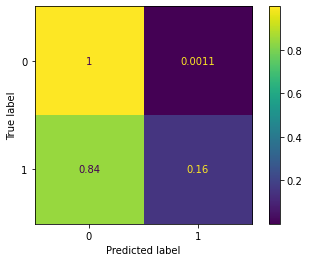

In [ ]:
print(plot_confusion_matrix(knn_female,female_X_test,female_y_test, normalize = 'true'))

In [ ]:
female_df['is_promoted'].value_counts(normalize=True)

0    0.910066
1    0.089934
Name: is_promoted, dtype: float64

In [ ]:
accuracy_score(female_y_test, female_preds)

0.9231712300776461

In [ ]:
accuracy_female_df = female_X_test.copy()
accuracy_female_df['actual'] = female_y_test
accuracy_female_df['pred'] = female_preds
accuracy_female_df['correct'] = accuracy_female_df['actual'] == accuracy_female_df['pred']

##male

In [ ]:
knn_male.fit(male_X_train, male_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [ ]:
male_preds = knn_male.predict(male_X_test)

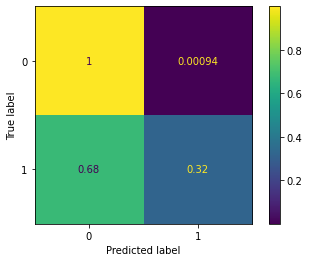

In [ ]:
print(plot_confusion_matrix(knn_male,male_X_test,male_y_test, normalize = 'true'))

In [ ]:
male_df['is_promoted'].value_counts(normalize=True)

0    0.916849
1    0.083151
Name: is_promoted, dtype: float64

In [ ]:
accuracy_score(male_y_test, male_preds)

0.9429387825785782

#Creating Model for Aggregate Model

In [ ]:
import joblib

In [ ]:
joblib.dump(knn_female, drive_dir + 'knn_female.joblib')

['/content/drive/My Drive/Project_3/knn_female.joblib']

In [ ]:
joblib.dump(knn_male, drive_dir + 'knn_male.joblib')

['/content/drive/My Drive/Project_3/knn_male.joblib']

#Label encoded model based on % promoted

In [ ]:
le_knn_female = KNeighborsClassifier(n_neighbors=3, weights = 'uniform')

In [ ]:
le_knn_female.fit(le_female_X_train, le_female_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
le_female_preds = le_knn_female.predict(le_female_X_test)

In [ ]:
accuracy_score(le_female_y_test, le_female_preds)

0.9119329791581529

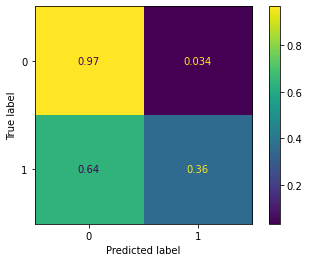

In [ ]:
print(plot_confusion_matrix(le_knn_female,le_female_X_test,le_female_y_test, normalize = 'true'))

In [ ]:
joblib.dump(le_knn_female, drive_dir + 'knn_female.joblib')

['/content/drive/My Drive/Project_3/knn_female.joblib']

#Checking where the models predicts wrong

In [ ]:
female_X_test.columns

NameError: ignored

In [ ]:
check_acc_female_df = female_test_df.copy()

NameError: ignored

In [ ]:
check_acc_female_df['pred'] = female_preds

In [ ]:
wrong_female_pred_df = check_acc_female_df[check_acc_female_df['is_promoted'] != check_acc_female_df['pred']]

In [ ]:
wrong_female_pred_df

In [ ]:
correct_female_pred_df = check_acc_female_df[check_acc_female_df['is_promoted'] == check_acc_female_df['pred']]

In [ ]:
correct_female_pred_df

In [ ]:
def make_hist(column, incorrect_df, correct_df):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax1 = incorrect_df[column].plot(kind='hist', ax=axes[0])
  ax2 = correct_df[column].plot(kind='hist', ax =axes[1])
  ax1.set_title(f'Incorrect for {column}')
  ax2.set_title(f'Correct for {column}')

In [ ]:
for col in female_X_test.columns:  
  make_hist(col, wrong_female_pred_df,correct_female_pred_df)